# Assignment 1 - Luise Kutzner, Lara Ruschmeyer, Eva Franck

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor

from sklearn.utils import (
    _safe_indexing,
    check_random_state,
    indexable,
    metadata_routing,
)


# Task 1: Setting the Baseline

In [2]:
# function to transform the dataset into a DataFrame where each sample is labeled with 
# a 'trajectory_id' indicating which 258-sample trajectory it belongs to

def transform_to_trajectories_dataframe(X_data, idx):
    
    transformed_data = []
    
    # iterate through the indices list to slice the dataframe into stacks
    for i in range(len(idx) - 1):
        # each stack corresponds to samples from idx[i] to idx[i + 1]
        start_idx = idx[i]
        end_idx = idx[i + 1]
        
        trajectory = X_data.iloc[start_idx:end_idx].copy()
        
        trajectory['trajectory_id'] = i
        
        transformed_data.append(trajectory)
    
    result_df = pd.concat(transformed_data, ignore_index=True)
    
    return result_df


In [3]:
# removes trajectories from the dataset that have duplicated initial positions 

def remove_duplicated_trajectories(X_data, trajectory_col='trajectory_id'):
    
    first_samples = X_data.groupby(trajectory_col).first().reset_index()
    
    duplicated_first_samples = first_samples.duplicated(subset=X_data.columns.difference([trajectory_col]), keep='first')

    true_count = duplicated_first_samples.sum()
    index = duplicated_first_samples[duplicated_first_samples].index
    print(f"Found {true_count} duplicated first samples with indices {index}.")
    
    unique_trajectories = first_samples.loc[~duplicated_first_samples, trajectory_col]
    
    cleaned_data = X_data[X_data[trajectory_col].isin(unique_trajectories)]

    return cleaned_data


In [4]:
 # validation helper to check if the test/test sizes are meaningful with regard to 
 # the size of the data (used in test split function from sklearn)
    
def _validate_shuffle_split(n_samples, test_size, train_size, default_test_size=None):
   
    if test_size is None and train_size is None:
        test_size = default_test_size

    test_size_type = np.asarray(test_size).dtype.kind
    train_size_type = np.asarray(train_size).dtype.kind

    if (
        test_size_type == "i"
        and (test_size >= n_samples or test_size <= 0)
        or test_size_type == "f"
        and (test_size <= 0 or test_size >= 1)
    ):
        raise ValueError(
            "test_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(test_size, n_samples)
        )

    if (
        train_size_type == "i"
        and (train_size >= n_samples or train_size <= 0)
        or train_size_type == "f"
        and (train_size <= 0 or train_size >= 1)
    ):
        raise ValueError(
            "train_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(train_size, n_samples)
        )

    if train_size is not None and train_size_type not in ("i", "f"):
        raise ValueError("Invalid value for train_size: {}".format(train_size))
    if test_size is not None and test_size_type not in ("i", "f"):
        raise ValueError("Invalid value for test_size: {}".format(test_size))

    if train_size_type == "f" and test_size_type == "f" and train_size + test_size > 1:
        raise ValueError(
            "The sum of test_size and train_size = {}, should be in the (0, 1)"
            " range. Reduce test_size and/or train_size.".format(train_size + test_size)
        )

    if test_size_type == "f":
        n_test = ceil(test_size * n_samples)
    elif test_size_type == "i":
        n_test = float(test_size)

    if train_size_type == "f":
        n_train = floor(train_size * n_samples)
    elif train_size_type == "i":
        n_train = float(train_size)

    if train_size is None:
        n_train = n_samples - n_test
    elif test_size is None:
        n_test = n_samples - n_train

    if n_train + n_test > n_samples:
        raise ValueError(
            "The sum of train_size and test_size = %d, "
            "should be smaller than the number of "
            "samples %d. Reduce test_size and/or "
            "train_size." % (n_train + n_test, n_samples)
        )

    n_train, n_test = int(n_train), int(n_test)

    if n_train == 0:
        raise ValueError(
            "With n_samples={}, test_size={} and train_size={}, the "
            "resulting train set will be empty. Adjust any of the "
            "aforementioned parameters.".format(n_samples, test_size, train_size)
        )

    return n_train, n_test

In [5]:
# Redefine split function from sklearn for training and test set based on trajectories

def train_test_split_traj(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None, trajectory_col='trajectory_id'):

    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    # the first array should be the dataframe with trajectory column, otherwise raise error
    if isinstance(arrays[0], pd.DataFrame) and trajectory_col in arrays[0].columns:
        X_data = arrays[0]
        unique_trajectories = X_data[trajectory_col].unique()
    else:
        raise ValueError(f"The first array must be a DataFrame containing the column '{trajectory_col}'.")

    n_trajectories = len(unique_trajectories)
    
    # determine number of trajectories for training and testing
    n_train, n_test = _validate_shuffle_split(
        n_trajectories, test_size, train_size, default_test_size=0.25
    )

    # shuffle trajectories if needed
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(unique_trajectories)

    if stratify is not None:
        raise ValueError("Stratified train/test split is not implemented for trajectories")

    # Split trajectories into training and test sets
    train_trajectories = unique_trajectories[:n_train]
    test_trajectories = unique_trajectories[n_train:n_train + n_test]

    # Create masks for train and test trajectories
    train_mask = X_data[trajectory_col].isin(train_trajectories)
    test_mask = X_data[trajectory_col].isin(test_trajectories)

    split_arrays = []
    for array in arrays:
        if isinstance(array, pd.DataFrame):
            train_array = array[train_mask]
            test_array = array[test_mask]
        else:
            train_array = array[train_mask.to_numpy()]
            test_array = array[test_mask.to_numpy()]

        split_arrays.extend([train_array, test_array])

    return split_arrays


In [6]:
# splits the dataset based on trajectories identified by the trajectory_id column into training, validation and test sets
# this or the function before
def train_validate_test_split(*arrays, test_size=None, validate_size=None, train_size=None, random_state=None, shuffle=True, trajectory_col='trajectory_id'):
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    if isinstance(arrays[0], pd.DataFrame) and trajectory_col in arrays[0].columns:
        X_data = arrays[0]
        unique_trajectories = X_data[trajectory_col].unique()
    else:
        raise ValueError(f"The first array must be a DataFrame containing the column '{trajectory_col}'.")

    n_trajectories = len(unique_trajectories)

    # split the data into training and (validation + test)
    n_train, n_temp = _validate_shuffle_split(
        n_trajectories, test_size + validate_size, train_size, default_test_size=0.25
    )

    # shuffle trajectories if needed
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(unique_trajectories)

    # split into train and temporary sets
    train_trajectories = unique_trajectories[:n_train]
    temp_trajectories = unique_trajectories[n_train:n_train + n_temp]

    # further split temporary set into validation and test sets
    n_validate = int(validate_size * n_trajectories)
    validate_trajectories = temp_trajectories[:n_validate]
    test_trajectories = temp_trajectories[n_validate:]

    # create masks for train, validation and test trajectories
    train_mask = X_data[trajectory_col].isin(train_trajectories)
    validate_mask = X_data[trajectory_col].isin(validate_trajectories)
    test_mask = X_data[trajectory_col].isin(test_trajectories)

    split_arrays = []
    for array in arrays:
        if isinstance(array, pd.DataFrame):
            train_array = array[train_mask]
            validate_array = array[validate_mask]
            test_array = array[test_mask]
        else:
            train_array = array[train_mask.to_numpy()]
            validate_array = array[validate_mask.to_numpy()]
            test_array = array[test_mask.to_numpy()]

        split_arrays.extend([train_array, validate_array, test_array])

    return split_arrays


## Task 1.1 Data Preparation and Validation Pipeline

In [7]:
data = pd.read_csv('../mlNOVA/X_train.csv')

In [8]:
data.head()


,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [9]:
data.loc[255:260]

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
255,9.960940,1.491492,1.199018,-0.063145,0.595242,1.018416,1.248499,0.674080,-0.034194,-2.509908,-2.447517,-0.610936,-0.561048,255
256,10.000000,1.485476,1.222565,-0.250131,0.609230,1.048258,1.246830,0.859066,-0.050144,-2.533734,-2.469395,-0.608935,-0.559086,256
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,-0.555739,0.000000,0.000000,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,-0.555279,0.022176,0.023556,258
259,0.078125,0.997564,0.000525,-0.062415,0.013460,-0.175799,0.553372,0.017992,-0.060639,-0.821765,-0.553898,0.044423,0.047179,259
260,0.117188,0.994513,0.001183,-0.093859,0.020224,-0.174920,0.550408,0.027043,-0.091163,-0.819593,-0.551591,0.066816,0.070939,260


In [10]:
# find the indices where a new trajectory starts
idx = np.hstack((0, data[data.t == 10].index.values + 1))[:-1]

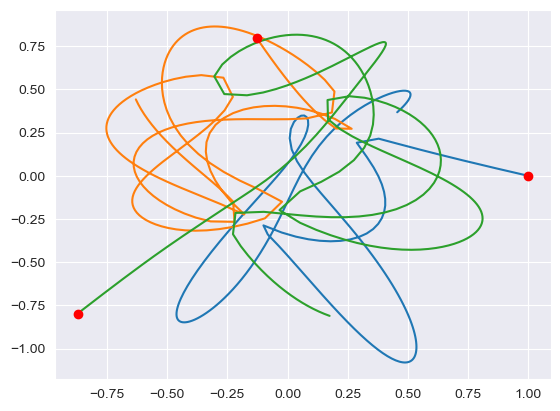

In [11]:
# plot a random trajectory 

k = np.random.randint(idx.shape[0])
pltidx = range(idx[k], 257 + idx[k])
pltsquare = idx[k]

plt.plot(data.x_1[pltidx], data.y_1[pltidx])
plt.plot(data.x_2[pltidx], data.y_2[pltidx])
plt.plot(data.x_3[pltidx], data.y_3[pltidx])

plt.plot(data.x_1[pltsquare], data.y_1[pltsquare], 'ro')
plt.plot(data.x_2[pltsquare], data.y_2[pltsquare], 'ro')
plt.plot(data.x_3[pltsquare], data.y_3[pltsquare], 'ro')

In [12]:
# drop Id column as it is unnecessary for the model
data_cleaned = data.drop(columns=['Id'])
#'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 

In [13]:
# Extract the X data and bring it into a form such that you have the initial conditions 
# along with the time t at which y describes the current x and y positions

X_data = data_cleaned.copy()
for i in idx:
    # select the first sample's column values in the current trajectory
    x_1_value = data_cleaned.loc[i, 'x_1']
    y_1_value = data_cleaned.loc[i, 'y_1']
    x_2_value = data_cleaned.loc[i, 'x_2']
    y_2_value = data_cleaned.loc[i, 'y_2']
    x_3_value = data_cleaned.loc[i, 'x_3']
    y_3_value = data_cleaned.loc[i, 'y_3']
    
    # update the column values for all 258 samples in this trajectory
    X_data.loc[i:i+257, 'x_1'] = x_1_value
    X_data.loc[i:i+257, 'y_1'] = y_1_value
    X_data.loc[i:i+257, 'x_2'] = x_2_value
    X_data.loc[i:i+257, 'y_2'] = y_2_value
    X_data.loc[i:i+257, 'x_3'] = x_3_value
    X_data.loc[i:i+257, 'y_3'] = y_3_value
    X_data.loc[i:i+257, 'v_x_1'] = 0
    X_data.loc[i:i+257, 'v_y_1'] = 0
    X_data.loc[i:i+257, 'v_x_2'] = 0
    X_data.loc[i:i+257, 'v_y_2'] = 0
    X_data.loc[i:i+257, 'v_x_3'] = 0
    X_data.loc[i:i+257, 'v_y_3'] = 0


In [14]:
X_data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3
0,0.000000,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
1,0.039062,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
2,0.078125,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
3,0.117188,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
4,0.156250,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0


In [15]:
# copy the X_train data to obtain y_data dataframe which are the positions 
# and velocities of all three objects at a certain time t
y_data = data_cleaned.copy()

In [16]:
# add a trajectory_id flag such that the data can be split into trajectories (function is defined above)
X_data_traj = transform_to_trajectories_dataframe(X_data, idx)
y_data_traj = transform_to_trajectories_dataframe(y_data, idx)


In [17]:
# remove trajectories with duplicated initial positions (function is defined above)
cleaned_X_data = remove_duplicated_trajectories(X_data_traj, trajectory_col='trajectory_id')
cleaned_y_data = remove_duplicated_trajectories(y_data_traj, trajectory_col='trajectory_id')

Found 1 duplicated first samples with indices Index([3297], dtype='int64').
Found 1 duplicated first samples with indices Index([3297], dtype='int64').


In [18]:
# split data into training, validation and test sets with the training size of 70%, validation size of 15% and test size of 15% (function is defined above)
X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(cleaned_X_data, cleaned_y_data, validate_size= 0.15, test_size=0.15)

Remove the trajectory_id column as it was only necessary for the splitting once with t in training and validation data, once without and once only in training data

In [19]:
# Remove the trajectory_id column for all sets and t for the y_datasets 
# because the model should only predict the positions

X_train = X_train.drop(columns=['trajectory_id'])
X_val = X_val.drop(columns=['trajectory_id'])
X_test = X_test.drop(columns=['trajectory_id'])
y_train = y_train.drop(columns=['trajectory_id', 't'])
y_val = y_val.drop(columns=['trajectory_id', 't'])
y_test = y_test.drop(columns=['trajectory_id', 't'])

## 1.2 Learn the baseline model

In [20]:
# create pipeline with a standard scaler and a linear regression model
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())  
])


pipeline.fit(X_train, y_train)
pipeline['regressor'].score(X_train, y_train)
#pipeline['regressor'].coef_
#pipeline['regressor'].intercept_

/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-1007749797064131.6

In [21]:
# predict y values for the validation set
y_val_pred = pipeline.predict(X_val)

In [22]:
# make a dataframe out of the true and predicted y values for the validation set to compare them
# and calculate the root mean squared error for the predicted values of the validation set 
# in comparison to the true values and for that drop the velocities from the dataframe
X_val_without_t = X_val.drop(columns=['t'])
y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val_without_t.columns)
y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.184651492255368


In [23]:
# function to plot the true values against the predicted values for the validation set

def plot_y_yhat(y_val,y_pred, plot_title):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3, 2, i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.jpg')
    plt.show()

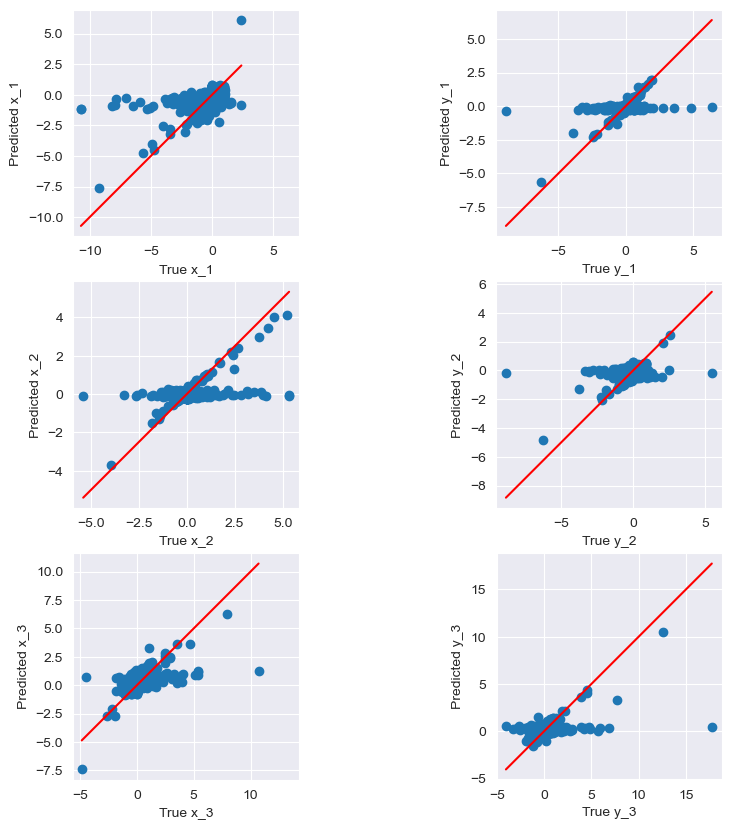

In [24]:
# make a numpy array out of y_val and plot it against the predicted values with the function above
y_val_np = y_val.to_numpy()
y_pred_np = y_val_pred_df.to_numpy()
plot_y_yhat(y_val_np,y_pred_np,"y-y_hat-plot_baseline")

In [25]:
# bring the data that we should apply the model on in the right format
# and predict the y values with our model
#data2 = pd.read_csv('../mlNOVA/X_test.csv')
data2 = pd.read_csv('../mlNOVA/X_test.csv')

data2['x_1'] = data2['x0_1']
data2['y_1'] = data2['y0_1']
data2['v_x_1'] = 0
data2['v_y_1'] = 0
data2['x_2'] = data2['x0_2']
data2['y_2'] = data2['y0_2']
data2['v_x_2'] = 0
data2['v_y_2'] = 0
data2['x_3'] = data2['x0_3']
data2['y_3'] = data2['y0_3']
data2['v_x_3'] = 0
data2['v_y_3'] = 0

data2 = data2.drop(columns=['Id', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3'])


y_data2 = pipeline.predict(data2)

# save y values for the data we should test the model on in the right format for kaggle
y_data2 = pd.DataFrame(y_data2, columns=X_val_without_t.columns)
y_data2['id'] = y_data2.index

columns_titles = ['id', 't', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
y_data2=y_data2.reindex(columns=columns_titles)
y_data2.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_data2.to_csv('baseline_model.csv',index=False)

In [26]:
# # bring the data that we should apply the model on in the right format
# # and predict the y values with our model
# data2 = pd.read_csv('../mlNOVA/X_test.csv')

# data2['x_1'] = data2['x0_1']
# data2['y_1'] = data2['y0_1']
# data2['v_x_1'] = 0
# data2['v_y_1'] = 0
# data2['x_2'] = data2['x0_2']
# data2['y_2'] = data2['y0_2']
# data2['v_x_2'] = 0
# data2['v_y_2'] = 0
# data2['x_3'] = data2['x0_3']
# data2['y_3'] = data2['y0_3']
# data2['v_x_3'] = 0
# data2['v_y_3'] = 0

# data2 = data2.drop(columns=['Id', 't', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3'])


# y_data2 = pipeline.predict(data2)

# # save y values for the data we should test the model on in the right format for kaggle
# y_data2 = pd.DataFrame(y_data2, columns=X_val.columns)
# y_data2['id'] = y_data2.index

# columns_titles = ['id', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
#        'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
# y_data2=y_data2.reindex(columns=columns_titles)
# y_data2.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_data2.to_csv('sample_submission.csv',index=False)

# Task 2: Nonlinear models on the data - the Polynomial Regression Model

## Task 2.1 Development

In [27]:
# split the data again into training, validation and test sets with the training size of 70%, validation size of 15% and test size of 15%
X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(cleaned_X_data, cleaned_y_data, validate_size= 0.15, test_size=0.15)

In [28]:
# sample 1% of the sets with keeping the trajectory structure

def sample_trajectories(X, y, trajectory_col='trajectory_id', sample_fraction=0.01, random_state=42):

    unique_trajectories = X[trajectory_col].unique()
  
    sampled_trajectories = resample(unique_trajectories, n_samples=int(sample_fraction * len(unique_trajectories)), random_state=random_state)
    
    X_sampled = X[X[trajectory_col].isin(sampled_trajectories)]
    y_sampled = y[X[trajectory_col].isin(sampled_trajectories)]
    
    return X_sampled, y_sampled

X_train_sampled, y_train_sampled = sample_trajectories(X_train, y_train, sample_fraction=0.01)
X_val_sampled, y_val_sampled = sample_trajectories(X_val, y_val, sample_fraction=0.01)
X_test_sampled, y_test_sampled = sample_trajectories(X_test, y_test, sample_fraction=0.01)

In [29]:
y_val_sampled.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,trajectory_id
37522,0.000000,1.000000,0.000000,0.000000,0.000000,-0.310749,0.867947,0.000000,0.000000,-0.689251,-0.867947,0.000000,0.000000,111
37523,0.039062,0.999554,0.000074,-0.022818,0.003779,-0.310543,0.867540,0.010546,-0.020823,-0.689012,-0.867614,0.012273,0.017045,111
37524,0.078125,0.998217,0.000295,-0.045679,0.007566,-0.309924,0.866319,0.021113,-0.041684,-0.688292,-0.866615,0.024566,0.034118,111
37525,0.117188,0.995985,0.000665,-0.068623,0.011371,-0.308893,0.864282,0.031724,-0.062618,-0.687092,-0.864947,0.036899,0.051247,111
37526,0.156250,0.992854,0.001184,-0.091696,0.015204,-0.307445,0.861426,0.042400,-0.083664,-0.685409,-0.862610,0.049295,0.068461,111


In [30]:
# # Remove the trajectory_id column for all sets and t for the y_datasets
# otherwise (the prediction will overfit) the RSME will be much different from kaggle
X_train_sampled = X_train_sampled.drop(columns=['trajectory_id'])
X_val_sampled = X_val_sampled.drop(columns=['trajectory_id'])
X_test_sampled = X_test_sampled.drop(columns=['trajectory_id'])
y_train_sampled = y_train_sampled.drop(columns=['trajectory_id', 't'])
y_val_sampled = y_val_sampled.drop(columns=['trajectory_id', 't'])
y_test_sampled = y_test_sampled.drop(columns=['trajectory_id', 't'])

In [31]:
# perform polynomial regression with different polynomial degrees and different regressors
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    if regressor is None:
        regressor = LinearRegression()
    elif regressor == 'MultiTaskLassoCV':
        regressor = MultiTaskLassoCV(alphas=np.logspace(-6, 6, 10), cv = 5)
    elif regressor == 'RidgeCV':
        regressor = RidgeCV(alphas=np.logspace(-6, 6, 10), store_cv_values=True)
    else:
        raise ValueError("Invalid regressor type.")
    
    best_rmse = float('inf')
    rmse_dict = {}
    best_pipeline = None

    
    # iterate through the polynomial degrees
    for degree in degrees:
        # pipeline for polynomial regression
        pipeline = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=degree)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
        
        pipeline.fit(X_train, y_train)
        
        # number of features for each degree
        poly_features = pipeline.named_steps['poly']
        print(f'Degree: {degree}, Number of Features: {poly_features.n_output_features_}')
        
        if max_features is not None and poly_features.n_output_features_ > max_features:
            print(f"Skipping degree {degree} as it exceeds max_features={max_features}.")
            continue
        
        y_val_pred = pipeline.predict(X_val)
        
        num_features = pipeline.named_steps['poly'].n_output_features_
        
        # drop t and velocities from the dataframes to calculate the RMSE to compare the predicted values with the true values for all degrees
        X_val_without_t = X_val.drop(columns=['t'])
        y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val_without_t.columns)
        y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
        y_val_eval = y_val.copy()
        y_val_eval.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)

        rmse = np.sqrt(mean_squared_error(y_val_eval, y_val_pred_df))
        print(f'Degree: {degree}, RMSE: {rmse}')
        
        rmse_dict[degree] = rmse
        
        # update the best degree if the current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pipeline = pipeline
        
        if max_features is not None and num_features > max_features:
            break
        
    return rmse_dict, best_rmse, best_pipeline
    
    

In [36]:
# run the function 10 times that validates the polynomial regression with degrees from 1 to 15 and linear regressor
# degree auf 6 gesetzt!!!
linear_pipelines_list = []
for i in range(1):
    rmse_dict_linear, best_rmse_linear, best_pipeline_linear = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor=None, degrees=range(1,6), max_features=None)
    linear_pipelines_list.append(best_pipeline_linear)

Degree: 1, Number of Features: 14
Degree: 1, RMSE: 1.0172104281975582
Degree: 2, Number of Features: 105
Degree: 2, RMSE: 17.829748470637874
Degree: 3, Number of Features: 560
Degree: 3, RMSE: 346.3588625395488
Degree: 4, Number of Features: 2380
Degree: 4, RMSE: 87561.54208553328
Degree: 5, Number of Features: 8568
Degree: 5, RMSE: 8187221845.39311


In [37]:
# run the function 10 times that validates the polynomial regression with degrees from 1 to 15 and Lasso regressor
# degree auf 6 gesetzt!!!
lasso_pipelines_list = []
for i in range(1):
    rmse_dict_lasso, best_rmse_lasso, best_pipeline_lasso = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor='MultiTaskLassoCV', degrees=range(1,6), max_features=None)
    lasso_pipelines_list.append(best_pipeline_lasso)

Degree: 1, Number of Features: 14
Degree: 1, RMSE: 0.9705242172607692


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3067.807876113693, tolerance: 13.022475871894992
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14869.372341196551, tolerance: 13.022475871894992
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16932.79833460983, tolerance: 13.022475871894992
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/

Degree: 2, Number of Features: 105
Degree: 2, RMSE: 4.357744410159224


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1019.3742197130414, tolerance: 13.022475871894992
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27558.63753022379, tolerance: 13.022475871894992
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31203.44294024275, tolerance: 13.022475871894992
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/

KeyboardInterrupt: 

In [38]:
# validate the polynomial regression with degrees from 1 to 7 and RidgeCV regressor
# run the function 10 times that validates the polynomial regression with degrees from 1 to 15 and Lasso regressor
# degree auf 6 gesetzt!!!
ridge_pipelines_list = []
for i in range(1):
    rmse_dict_ridge, best_rmse_ridge, best_pipeline_ridge = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor='RidgeCV', degrees=range(1,6), max_features=None)
    ridge_pipelines_list.append(best_pipeline_ridge)
    

/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Degree: 1, Number of Features: 14
Degree: 1, RMSE: 0.9611016713668534
Degree: 2, Number of Features: 105
Degree: 2, RMSE: 8.543879341954606


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Degree: 3, Number of Features: 560
Degree: 3, RMSE: 140.6267787759445


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Degree: 4, Number of Features: 2380
Degree: 4, RMSE: 604.4081240772999


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Degree: 5, Number of Features: 8568
Degree: 5, RMSE: 4844.059645905795


In [39]:
# plot that shows distribution of best performing polynomial degrees for the linear regressor
selected_degrees_linear = []

for pipeline in linear_pipelines_list:
    selected_degrees_linear.append(pipeline.named_steps['poly'].degree)
    
selected_degrees_lasso = []

for pipeline in lasso_pipelines_list:
    selected_degrees_lasso.append(pipeline.named_steps['poly'].degree)

selected_degrees_ridge = []

for pipeline in ridge_pipelines_list:
    selected_degrees_ridge.append(pipeline.named_steps['poly'].degree)


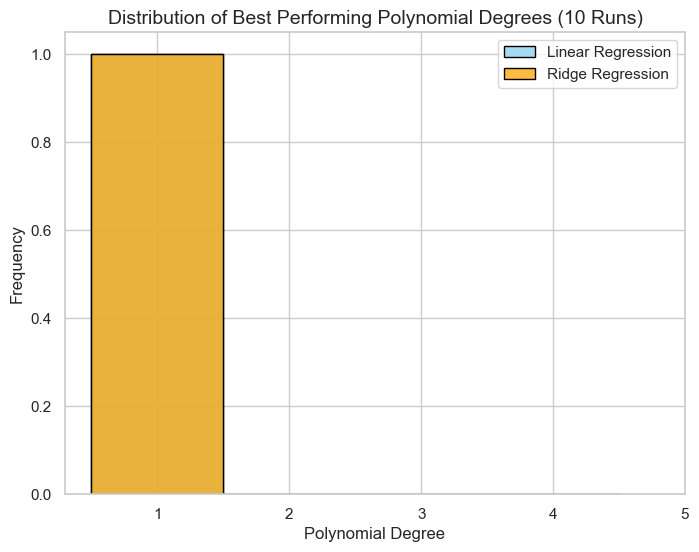

In [40]:
# plot that shows distribution of best performing polynomial degrees for the Lasso regressor

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(selected_degrees_linear, bins=np.arange(1, 6)-0.5, kde=False, color='skyblue', edgecolor='black', label='Linear Regression')
sns.histplot(selected_degrees_lasso, bins=np.arange(1, 6)-0.5, kde=False, color='red', edgecolor='black', label='Lasso Regression')
sns.histplot(selected_degrees_ridge, bins=np.arange(1, 6)-0.5, kde=False, color='orange', edgecolor='black', label='Ridge Regression')
plt.title('Distribution of Best Performing Polynomial Degrees (10 Runs)', fontsize=14)
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(np.arange(1, 6))
plt.grid(True)
plt.legend()
plt.show()


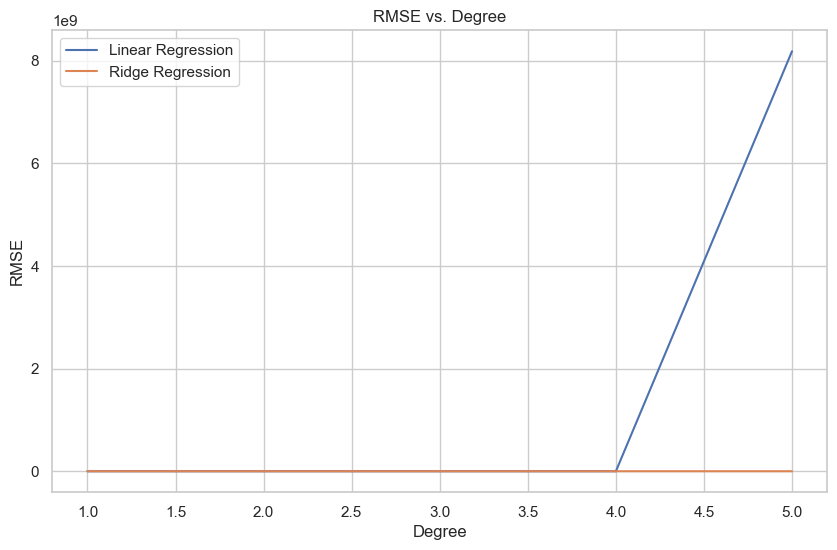

<Figure size 640x480 with 0 Axes>

In [41]:
# make a plot of the distribution of the different polynomial degrees

plt.figure(figsize=(10,6))
plt.plot(*zip(*rmse_dict_linear.items()), label='Linear Regression')
plt.plot(*zip(*rmse_dict_lasso.items()), label='Lasso Regression')
plt.plot(*zip(*rmse_dict_ridge.items()), label='Ridge Regression')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.title('RMSE vs. Degree')
plt.legend()
plt.show()
plt.savefig('RMSE_vs_Degree.jpg')


In [42]:
# find the most often best performing degree for each regressor

counter = Counter(selected_degrees_linear)
most_used_degree_linear, frequency = counter.most_common(1)[0]
counter = Counter(selected_degrees_lasso)
most_used_degree_lasso, frequency = counter.most_common(1)[0]
counter = Counter(selected_degrees_ridge)
most_used_degree_ridge, frequency = counter.most_common(1)[0]

print(f"Most often the degree {most_used_degree_linear} is the best performing degree for linear regression.")
print(f"Most often the degree {most_used_degree_lasso} is the best performing degree for Lasso regression.")
print(f"Most often the degree {most_used_degree_ridge} is the best performing degree for Ridge regression.")


IndexError: list index out of range

In [49]:
s

NameError: name 's' is not defined

## Task 2.2 Evaluation

In [43]:
# # Remove the trajectory_id column for all sets and t for the y_datasets
# otherwise (the prediction will overfit) the RSME will be much different from kaggle
X_train = X_train.drop(columns=['trajectory_id'])
X_val = X_val.drop(columns=['trajectory_id'])
X_test = X_test.drop(columns=['trajectory_id'])
y_train = y_train.drop(columns=['trajectory_id', 't'])
y_val = y_val.drop(columns=['trajectory_id', 't'])
y_test = y_test.drop(columns=['trajectory_id', 't'])

In [44]:
# # RMSE for the best performing degree for each regressor in comparison to the RMSE of the baseline model

# linear regression with the best performing degree
pipeline = linear_pipelines_list[0]
pipeline.fit(X_train, y_train)
y_val_pred_linear = pipeline.predict(X_val)
X_val_without_t = X_val.drop(columns=['t'])
y_val_pred_df_linear = pd.DataFrame(y_val_pred_linear, columns=X_val_without_t.columns)
y_val_pred_df_linear.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df_linear))
print(f'Root Mean Squared Error for Linear Regression: {rmse}')

# # Lasso regression with the best performing degree
# pipeline = lasso_pipelines_list[0]
# pipeline.fit(X_train, y_train)
# y_val_pred_lasso = pipeline.predict(X_val)
# y_val_pred_df_lasso = pd.DataFrame(y_val_pred_lasso, columns=X_val_without_t.columns)
# y_val_pred_df_lasso.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df_lasso))
# print(f'Root Mean Squared Error for Lasso Regression: {rmse}')

# # Ridge regression with the best performing degree
# pipeline = ridge_pipelines_list[0]
# pipeline.fit(X_train, y_train)
# y_val_pred_ridge = pipeline.predict(X_val)
# y_val_pred_df_ridge = pd.DataFrame(y_val_pred_ridge, columns=X_val_without_t.columns)
# y_val_pred_df_ridge.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df_ridge))
# print(f'Root Mean Squared Error for Ridge Regression: {rmse}')

# # RMSE for the baseline model
# pipeline = Pipeline(steps=[
#     ('scaler', StandardScaler()), 
#     ('regressor', LinearRegression())  
# ])
# pipeline.fit(X_train, y_train)
# y_val_pred_baseline = pipeline.predict(X_val)
# y_val_pred_df_baseline = pd.DataFrame(y_val_pred_baseline, columns=X_val_without_t.columns)
# y_val_pred_df_baseline.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df_baseline))
# print(f'Root Mean Squared Error for Baseline Model: {rmse}')

Root Mean Squared Error for Linear Regression: 1.1425047098966243


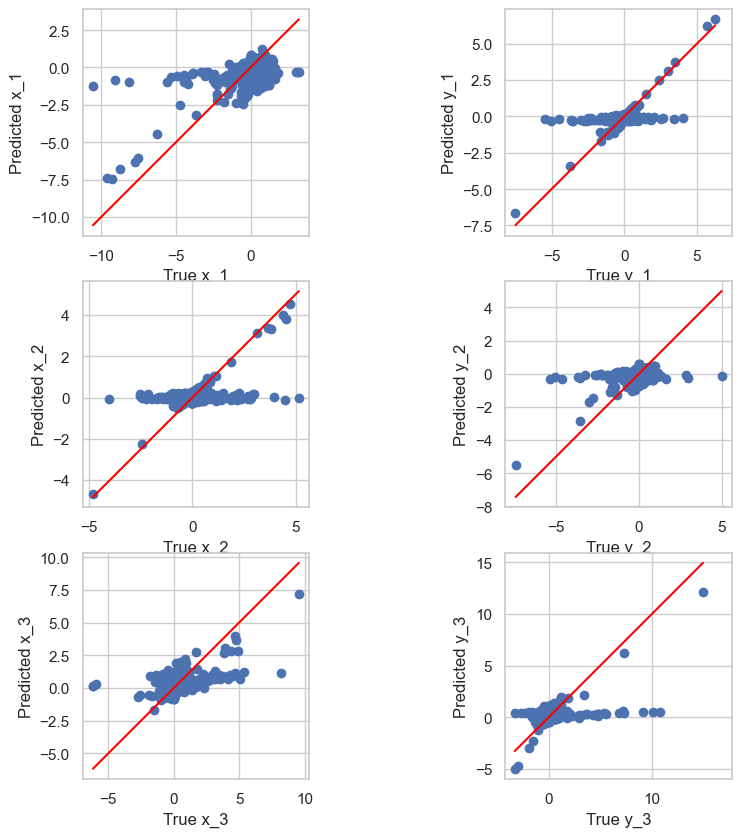

In [45]:
# compare y-y_hat plots for the best performing degree for each regressor with the baseline model

# linear regression with the best performing degree
y_val_np = y_val.to_numpy()
y_pred_linear_np = y_val_pred_df_linear.to_numpy()
plot_y_yhat(y_val_np,y_pred_linear_np,"y-y_hat-plot_linear")

In [46]:
# # Lasso regression with the best performing degree
# y_val_np = y_val.to_numpy()
# y_pred_lasso_np = y_val_pred_df_lasso.to_numpy()
# plot_y_yhat(y_val_np,y_pred_lasso_np,"y-y_hat-plot_lasso")

In [47]:
# # Ridge regression with the best performing degree
# y_val_np = y_val.to_numpy()
# y_pred_ridge_np = y_val_pred_df_ridge.to_numpy()
# plot_y_yhat(y_val_np,y_pred_ridge_np,"y-y_hat-plot_ridge")

In [48]:
# # baseline model
# y_val_np = y_val.to_numpy()
# y_pred_baseline_np = y_val_pred_df_baseline.to_numpy()
# plot_y_yhat(y_val_np,y_pred_baseline_np,"y-y_hat-plot_baseline")

In [68]:
# bring the data that we should apply the model on in the right format
# and predict the y values with best performing polynomial model
#data2 = pd.read_csv('../mlNOVA/X_test.csv')
data2 = pd.read_csv('../../mlNOVA/X_test.csv')

data2['x_1'] = data2['x0_1']
data2['y_1'] = data2['y0_1']
data2['v_x_1'] = 0
data2['v_y_1'] = 0
data2['x_2'] = data2['x0_2']
data2['y_2'] = data2['y0_2']
data2['v_x_2'] = 0
data2['v_y_2'] = 0
data2['x_3'] = data2['x0_3']
data2['y_3'] = data2['y0_3']
data2['v_x_3'] = 0
data2['v_y_3'] = 0

data2 = data2.drop(columns=['Id', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3'])


y_data2 = selected_pipeline.predict(data2)

# save y values for the data we should test the model on in the right format for kaggle
y_data2 = pd.DataFrame(y_data2, columns=X_val_without_t.columns)
y_data2['id'] = y_data2.index

columns_titles = ['id', 't', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
y_data2=y_data2.reindex(columns=columns_titles)
y_data2.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_data2.to_csv('polynomial_submission.csv',index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../mlNOVA/X_test.csv'

# Task 3: Feature Engineering

## Task 3.1 Removing variables

Explore the features and verify if there are any linear relationships between them. 

Remember, features should be uncorrelated with each other and highly correlated with the target variables. Use the Seaborn package to inspect these relationships.

In [67]:
# required packages
import seaborn as sns
from sklearn.metrics import mean_squared_error

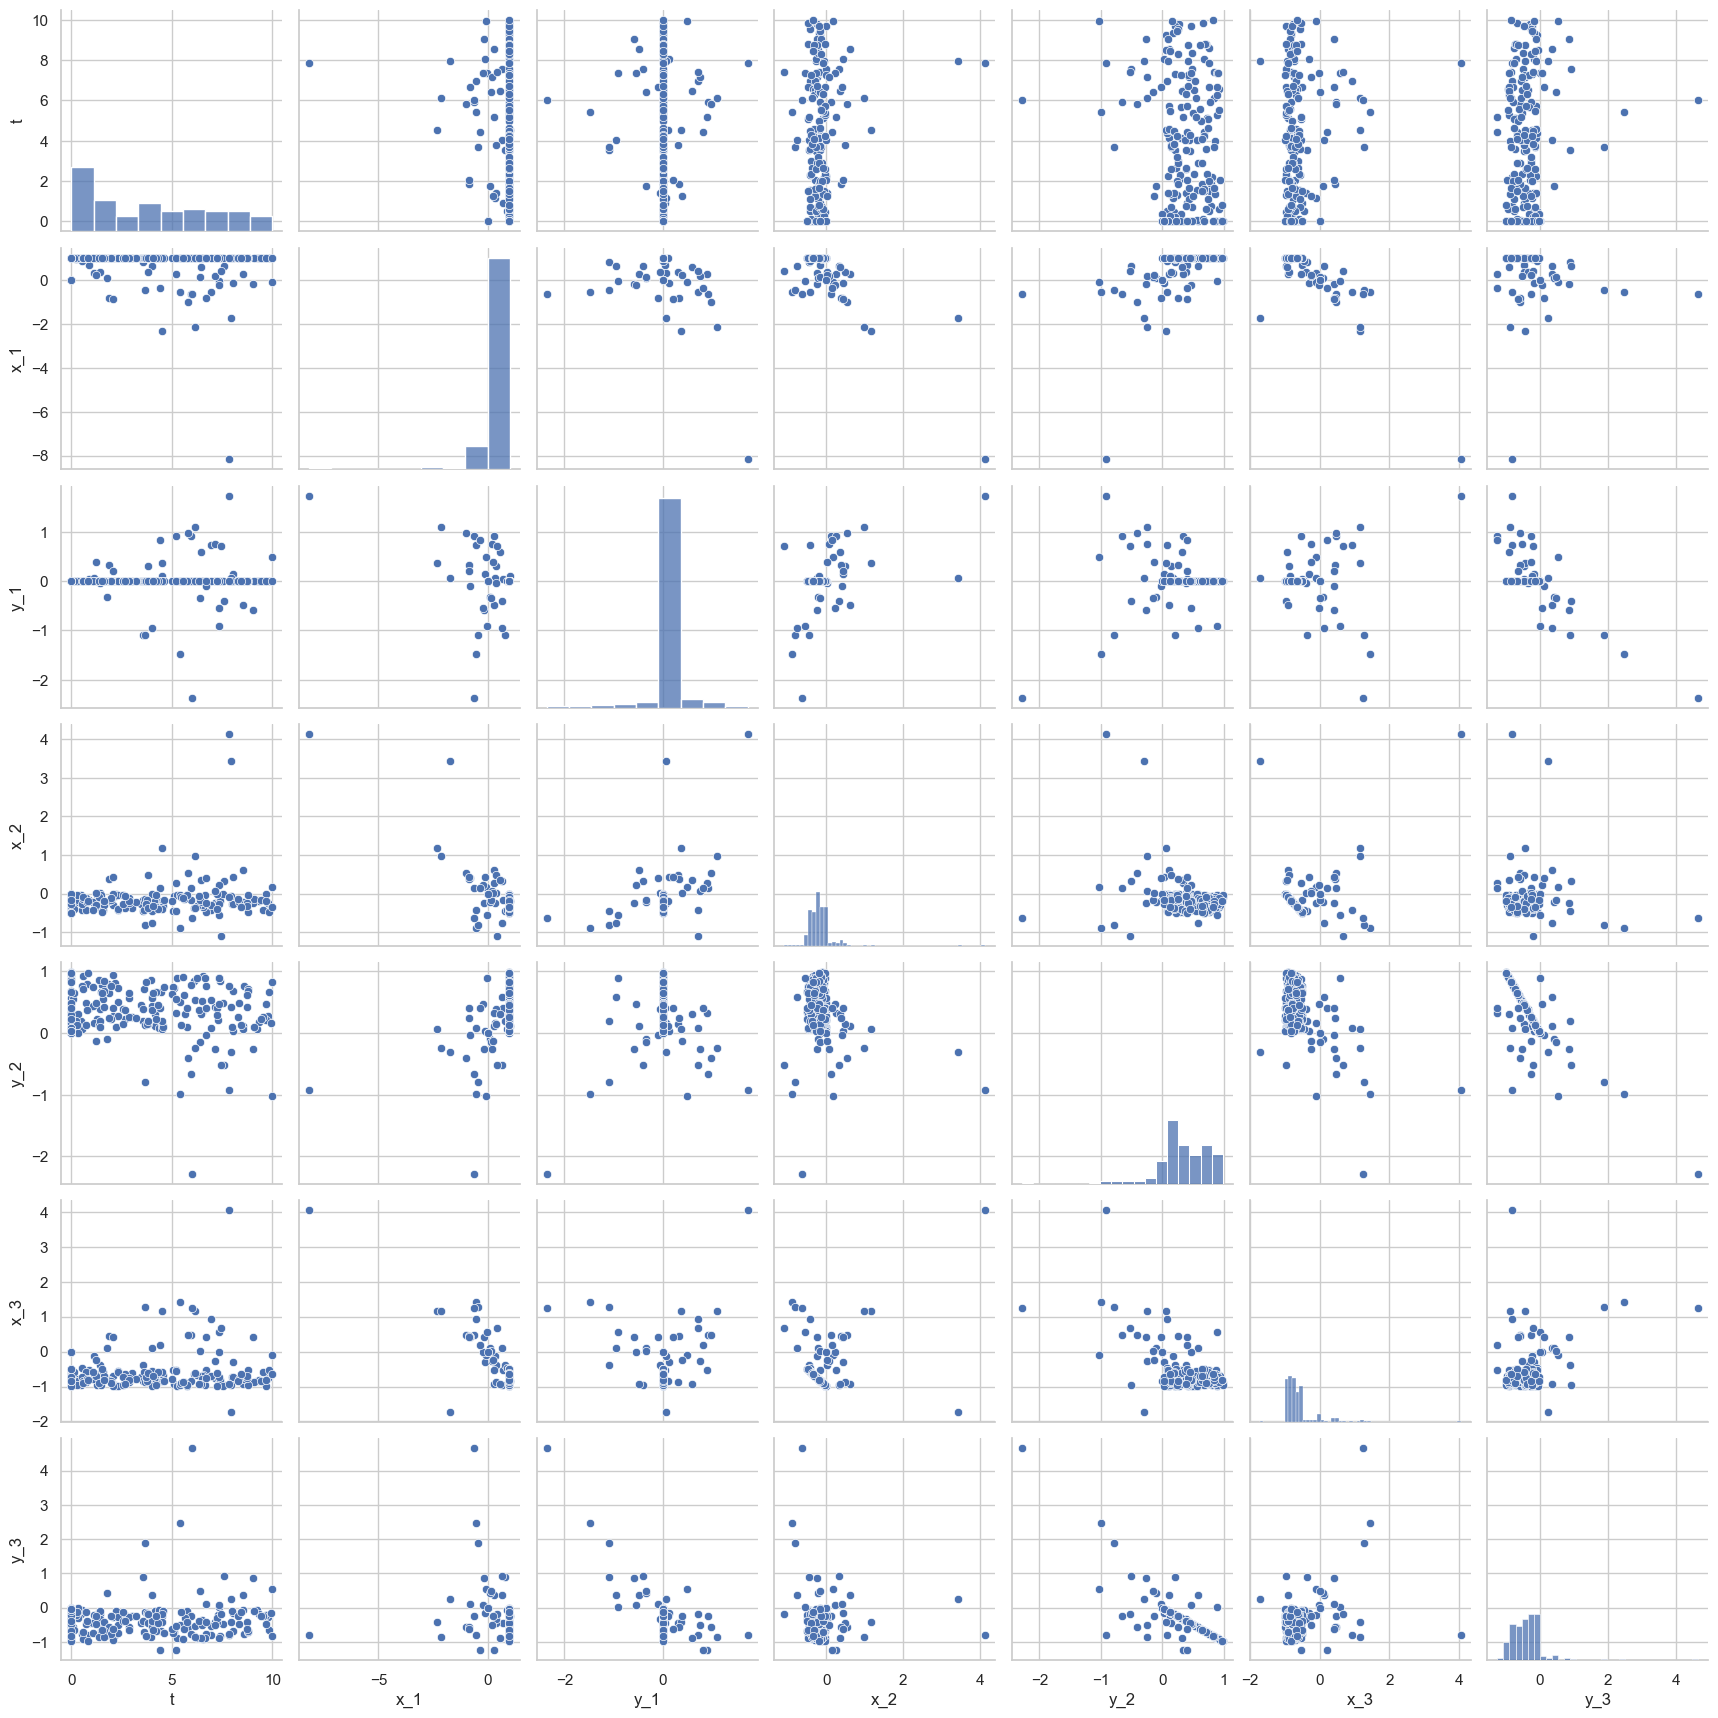

In [50]:
# drop velocities because there all 0 anyway at the start
# so there will be no correlation
X_train_without_v = X_train.drop(['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'], axis=1)

# Sample a subset of the data
sampled_data = X_train_without_v.sample(200, random_state=42)

# Pairplot for visualizing relationships between positions and velocities
sns.pairplot(sampled_data, kind="scatter")
plt.show()

<Axes: >

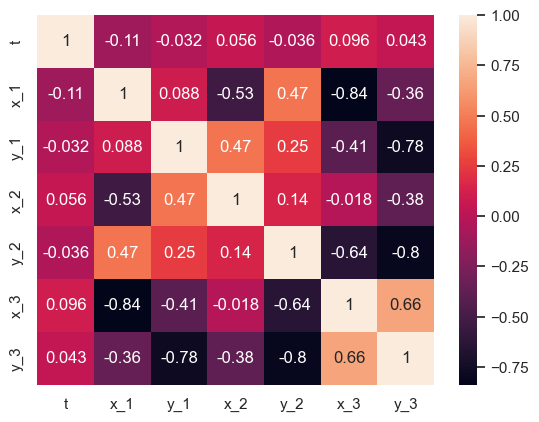

In [51]:
# check linear correlations with the heatmap
corr = X_train_without_v.corr()
#corr = y_train.corr()
sns.heatmap(corr,annot=True)

In [52]:
# sort values 
sorted_corr = corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
sorted_corr = sorted_corr[sorted_corr < 1.0]  # without self correlation

In [53]:
# top 10 highest correlations
print("Top 10 of Highest Correlation:")
print(sorted_corr.head(10))

Top 10 of Highest Correlation:
x_3  x_1    0.838152
x_1  x_3    0.838152
y_3  y_2    0.804956
y_2  y_3    0.804956
y_1  y_3    0.777226
y_3  y_1    0.777226
x_3  y_3    0.664840
y_3  x_3    0.664840
x_3  y_2    0.639874
y_2  x_3    0.639874
dtype: float64


### feature elimination after splitting

In [54]:
# remove velocities from X dataframe, because they are 0 anyway

X_train_wo_v = X_train.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'])
X_val_wo_v = X_val.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'])

In [55]:
# changing format of dataframes for the prediction

#def format_df_for_plot(df):
#    return df[['x_1','y_1','x_2','y_2','x_3','y_3']]

# Function to remove variables and evaluate performance

def remove_variables(x, train, validation, y_train, y_val, pipeline):
    redundant_variable = x  # Variable to remove
    
    # Drop the redundant variable from the training and validation sets
    X_train_reduced = train.drop(columns=[redundant_variable])
    X_val_reduced = validation.drop(columns=[redundant_variable])
    
    y_train_reduced = y_train.copy()
    y_val_reduced = y_val.copy()

    # Fit the pipeline on the reduced training set
    pipeline.fit(X_train_reduced, y_train_reduced)
    print(f"Training Score after removing {redundant_variable}: {pipeline['regressor'].score(X_train_reduced, y_train_reduced)}")

    # Predict on the reduced validation set
    y_val_pred_reduced = pipeline.predict(X_val_reduced)
   
    # Since the columns of y_val might not match those of X, use the columns of y_val for the prediction dataframe
    y_val_pred_2_df = pd.DataFrame(y_val_pred_reduced, columns=y_val_reduced.columns)
   
    # Calculate RMSE for the reduced model
    rmse_reduced = np.sqrt(mean_squared_error(y_val_reduced, y_val_pred_reduced))
    print(f'Root Mean Squared Error after removing {redundant_variable}: {rmse_reduced}') 

    # remove t column and id for y-y-hat-plot
    y_val_reduced_without_t = y_val_reduced.drop(['t','trajectory_id'], axis=1)
    y_val_pred_2_without_t = y_val_pred_2_df.drop(['t','trajectory_id'], axis=1)

    # Call the updated plot_y_yhat function with the predicted and true values
    plot_y_yhat(y_val_reduced_without_t.to_numpy(), y_val_pred_2_without_t.to_numpy())#, labels=y_val.columns)

    return rmse_reduced, X_train_reduced, X_val_reduced


In [69]:
# remove x3 from dataframe with velocities
rmse_x3, X_train_x3, X_val_x3 = remove_variables('x_3',X_train_wo_v,X_val_wo_v, y_train,y_val, pipeline)

/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 6 features, but LinearRegression is expecting 7 features as input.

In [64]:
# remove y1
rmse_x3y1, X_train_x3y1, X_val_x3y1 = remove_variables('y_1',X_train_x3,X_val_x3, y_train,y_val, pipeline)

NameError: name 'X_train_x3' is not defined

In [70]:
# remove y2
rmse_x3y1y2, X_train_x3y1y2, X_val_x3y1y2 = remove_variables('y_2',X_train_x3y1,X_val_x3y1, y_train, y_val, pipeline)

NameError: name 'X_train_x3y1' is not defined

After removing y2 the rmse rises against, so it doesn't make sense to remove this feature

In [66]:
# removing x2 
rmse_x3y1x2, X_train_x3y1x2, X_val_x3y1x2 = remove_variables('x_2',X_train_x3y1,X_val_x3y1, y_train, y_val, pipeline)

NameError: name 'X_train_x3y1' is not defined

Removing x2, also increases the rmse, so it doesn't make sense

The final choice is to eliminate y1 and x3.

## Task 3.2 Evaluation of Variable Reduction

After deciding on variable reduction, run your validate_poly_regression function on the reduced feature set. Compare the performance with the model from Task 2 using RMSE and the y-y hat plot. Add the information and your comments to the slides. Submit to Kaggle with the name reduced_polynomial_submission.csv.

In [ ]:
# prepare data format for polynomial regressor
X_train_best_reduced = X_train_x3y1.drop(columns=['trajectory_id'])
X_val_best_reduced = X_val_x3y1.drop(columns=['trajectory_id'])
y_train_best_reduced = y_train.drop(columns=['t','trajectory_id'])
y_val_best_reduced = y_val.drop(columns=['t','trajectory_id'])

In [ ]:
# new function for polynomial regressor, just with small changes
# old one had a conflict with the slected data
# perform polynomial regression with different polynomial degrees and different regressors
def validate_poly_regression2(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    if regressor is None:
        regressor = LinearRegression()
    elif regressor == 'MultiTaskLassoCV':
        regressor = MultiTaskLassoCV(alphas=np.logspace(-6, 6, 10), cv = 5)
    elif regressor == 'RidgeCV':
        regressor = RidgeCV(alphas=np.logspace(-6, 6, 10), store_cv_values=True)
    else:
        raise ValueError("Invalid regressor type.")
    
    best_rmse = float('inf')
    rmse_dict = {}
    best_pipeline = None

    
    # iterate through the polynomial degrees
    for degree in degrees:
        # pipeline for polynomial regression
        pipeline = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=degree)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
        
        pipeline.fit(X_train, y_train)
        
        # number of features for each degree
        poly_features = pipeline.named_steps['poly']
        print(f'Degree: {degree}, Number of Features: {poly_features.n_output_features_}')
        
        if max_features is not None and poly_features.n_output_features_ > max_features:
            print(f"Skipping degree {degree} as it exceeds max_features={max_features}.")
            continue
        
        y_val_pred = pipeline.predict(X_val)
        #print(f"y_val shape: {y_val.shape}")
        #print(f"y_val_pred shape: {y_val_pred.shape}")
        
        num_features = pipeline.named_steps['poly'].n_output_features_
        
        #X_val_without_t = X_val.drop(columns=['t'])
        y_val_pred_df = pd.DataFrame(y_val_pred, columns=y_val.columns)
        y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
        y_val_eval = y_val.copy()
        y_val_eval.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)

        rmse = np.sqrt(mean_squared_error(y_val_eval, y_val_pred_df))
        print(f'Degree: {degree}, RMSE: {rmse}')
        
        rmse_dict[degree] = rmse
        
        # update the best degree if the current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pipeline = pipeline
        
        if max_features is not None and num_features > max_features:
            break
        
    return rmse_dict, best_rmse, best_pipeline
    
    

In [ ]:
# validate the polynomial regression linear regressor
rmse_dict_linear_reduced, best_rmse_linear_reduced, best_pipeline_linear_reduced = validate_poly_regression2(X_train_best_reduced, y_train_best_reduced,
X_val_best_reduced, y_val_best_reduced, regressor=None, degrees=range(1,3),max_features=None)

In [ ]:
# validate the polynomial regression RidgeCV regressor
rmse_dict_ridge_reduced, best_rmse_ridge_reduced, best_pipeline_ridge_reduced = validate_poly_regression2(X_train_best_reduced, y_train_best_reduced,
X_val_best_reduced, y_val_best_reduced, regressor='RidgeCV', degrees=range(1,3), max_features=None)

### Compare original and reduced model for the linear Regressor

In [ ]:
# dataframe for y-y-hat plot
y_val_o = y_val.drop(columns=['t','trajectory_id'])

# Predictions for original Pipeline
y_val_pred_original = best_pipeline_linear.predict(X_val.drop(columns=['trajectory_id']))
y_val_pred_original_df = pd.DataFrame(y_val_pred_original, columns=y_val_o.columns)
#y_val_pred_original_df = y_val_pred_original_df.drop(columns=['t','trajectory_id'])

# Plot y-y hat plot for original model
plot_y_yhat(y_val_o.to_numpy(), y_val_pred_original_df.to_numpy(), plot_title="Original Model y-y Plot")

In [ ]:
# Predictions for Pipeline with reduced Data
y_val_pred_reduced = best_pipeline_linear_reduced.predict(X_val_best_reduced)
y_val_pred_reduced_df = pd.DataFrame(y_val_pred_reduced, columns=y_val_o.columns)
#y_val_pred_original_df = y_val_pred_original_df.drop(columns=['t','trajectory_id'])

# Plot y-y hat plot for reduced model
plot_y_yhat(y_val_o.to_numpy(), y_val_pred_reduced_df.to_numpy(), plot_title="Reduced Model y-y Plot")

In [ ]:
# compare rmse 

print(f"Best RMSE for Original Model: {best_rmse_linear}")
print(f"Best RMSE for Reduced Model: {best_rmse_linear_reduced}")

In [ ]:
# now with the test data
# apply pipeline

data2_reduced = data2.drop(columns=['x_3','y_1','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'])

y_data2_reduced = best_pipeline_linear_reduced.predict(data2_reduced)
# save y values for the data we should test the model on in the right format for kaggle
#data3_reduced = data2_reduced.drop(co)
y_data2_reduced = pd.DataFrame(y_data2_reduced, columns=y_val_best_reduced.columns)
y_data2_reduced['id'] = y_data2_reduced.index

columns_titles = ['id', 't', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
y_data2_reduced=y_data2_reduced.reindex(columns=columns_titles)
y_data2_reduced.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_data2_reduced.to_csv('reduced_polynomial_submission.csv',index=False)

## 3.3 Task Adding Variables

Examine your feature pairplot attentively. Try creating new features, like inverses of quantities, norms, ratios, etc. Check the Wikipedia page of the three-body problem for other computations that might be good candidates. Test the new feature sets with the baseline. Document the evidence you obtained from these experiments, and write your conclusions, always backed by evidence, on your slides.

It doesn't make sense to look closer to features related to the velocities, because they are 0 anyway for the X dataset and the later on input data.

Start with adding the norm of the positions:
$\| \mathbf{r} \| = \sqrt{x^2 + y^2}$

In [ ]:
# add norm of the positions
def norm_position(df1):
    df = df1.copy()
    df['norm_1'] = np.sqrt(df['x_1']**2 + df['y_1']**2)
    df['norm_2'] = np.sqrt(df['x_2']**2 + df['y_2']**2)
    df['norm_3'] = np.sqrt(df['x_3']**2 + df['y_3']**2)

    return df

In [ ]:
# add feature
X_train_added = norm_position(X_train)
X_val_added = norm_position(X_val)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Prediction with added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# Calculate RMSE
rmse_norm = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"Baseline RMSE: {rmse}")
print(f"Norm RMSE: {rmse_norm}")

Adding the norm of the postion decreases the RMSE, so we keep it.

Now we try the relative distances:
e.g. $d_{12} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$


In [ ]:
# add relative distances

def relative_distance(df1):
    df = df1.copy()
    df['distance_12'] = np.sqrt((df['x_2'] - df['x_1'])**2 + (df['y_2'] - df['y_1'])**2)
    df['distance_13'] = np.sqrt((df['x_3'] - df['x_1'])**2 + (df['y_3'] - df['y_1'])**2)
    df['distance_23'] = np.sqrt((df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2)

    return df

In [ ]:
# add feature
X_train_added = relative_distance(X_train_added)
X_val_added = relative_distance(X_val_added)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Prediction with added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_relative = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")

slight increase of RMSE -> dosnt make sense to add the relative distance

Now for the ratios of the distances:
$r_{12,13} = \frac{d_{12}}{d_{13}} = \frac{\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}}{\sqrt{(x_3 - x_1)^2 + (y_3 - y_1)^2}}$


In [ ]:
# ratios of the distances

def ratio_distance(df1):
    df = df1.copy()

    df['distance_ratio_12_13'] = df['distance_12'] / df['distance_13']
    df['distance_ratio_12_23'] = df['distance_12'] / df['distance_23']
    df['distance_ratio_13_23'] = df['distance_13'] / df['distance_23']

    #df= df.drop(columns=['distance_12','distance_13','distance_23'])

    return df

In [ ]:
# add feature
X_train_added = ratio_distance(X_train_added)
X_val_added = ratio_distance(X_val_added)
X_train_added = X_train_added.fillna(0) 
X_val_added = X_val_added.fillna(0)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Prediction for added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_ratio = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")

In [ ]:
X_train_added = X_train_added.drop(columns=['distance_ratio_12_13','distance_ratio_12_23','distance_ratio_13_23'])
X_val_added = X_val_added.drop(columns=['distance_ratio_12_13','distance_ratio_12_23','distance_ratio_13_23'])

Now for the center of mass of the 3 bodies:
$x_{\text{cm}} = \frac{x_1 + x_2 + x_3}{3}$

In [ ]:
# center of mass
def center_mass(df1):
    df = df1.copy()

    df['x_cm'] = (df['x_1'] + df['x_2'] + df['x_3']) / 3
    df['y_cm'] = (df['y_1'] + df['y_2'] + df['y_3']) / 3
    
    return df


In [ ]:
# add feature
X_train_added = center_mass(X_train_added)
X_val_added = center_mass(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Predictions for added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_mass = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")

Es ergibt keinen Sinn die Schwerpunkte zu untersuchen, da diese immer 0 ergeben.

In [ ]:
X_train_added = X_train_added.drop(columns=['x_cm','y_cm'])
X_val_added = X_val_added.drop(columns=['x_cm','y_cm'])

Now the turn angle:
$\theta_{12} = \tan^{-1}\left(\frac{y_2 - y_1}{x_2 - x_1}\right)$

In [ ]:
# Angel

def turn_angle(df1):
    df = df1.copy()
    df['angle_12'] = np.arctan2(df['y_2'] - df['y_1'], df['x_2'] - df['x_1'])
    df['angle_13'] = np.arctan2(df['y_3'] - df['y_1'], df['x_3'] - df['x_1'])
    df['angle_23'] = np.arctan2(df['y_3'] - df['y_2'], df['x_3'] - df['x_2'])
    
    return df

In [ ]:
# add feature
X_train_added = turn_angle(X_train_added)
X_val_added = turn_angle(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Generate predictions for the validation set using the best augmented pipeline
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_angle = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")
print(f"Turn Angle RMSE: {rmse_angle}")

It makes sense to add the turn angle, because it decreases the RMSE

Now the squared distance between body 2 and 3, because for body one it doesn't make sense, since the postions are always 1 and 0.
$d_{12}^2 = (x_3 - x_2)^2 + (y_3 - y_2)^2$

In [ ]:
# squared distance of body 2 and 3
def squared_distance(df1):
    df = df1.copy()
    df['squared_distance_12'] = (df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2
    return df


In [ ]:
# add feature
X_train_added = squared_distance(X_train_added)
X_val_added = squared_distance(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Prediction with added fearure
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_squared = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")
print(f"Squared rel Distance RMSE: {rmse_angle}")
print(f"Turn Angle RMSE: {rmse_squared}")

In [ ]:
# Fläche des Dreiecks
def triangle_area(df1):
    df = df1.copy()
    df['area'] = 0.5 * np.abs(df['x_1'] * (df['y_2'] - df['y_3']) + 
                               df['x_2'] * (df['y_3'] - df['y_1']) + 
                               df['x_3'] * (df['y_1'] - df['y_2']))
    return df

In [57]:
# add feature
X_train_added = triangle_area(X_train_added)
X_val_added = triangle_area(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# Prediction for added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_triangle = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")
print(f"Turn Angle RMSE: {rmse_angle}")
print(f"Squared rel Distance RMSE: {rmse_squared}")
print(f"Triangle RMSE: {rmse_triangle}")

NameError: name 'triangle_area' is not defined

In [58]:
# define function for the features which decreased RMSE

def add_features(df1):

    df = df1.copy()

    # Compute position norms
    df['norm_1'] = np.sqrt(df['x_1']**2 + df['y_1']**2)
    df['norm_2'] = np.sqrt(df['x_2']**2 + df['y_2']**2)
    df['norm_3'] = np.sqrt(df['x_3']**2 + df['y_3']**2)

    df['squared_distance_12'] = (df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2

    df['area'] = 0.5 * np.abs(df['x_1'] * (df['y_2'] - df['y_3']) + 
                               df['x_2'] * (df['y_3'] - df['y_1']) + 
                               df['x_3'] * (df['y_1'] - df['y_2']))
    
    df['angle_12'] = np.arctan2(df['y_2'] - df['y_1'], df['x_2'] - df['x_1'])
    df['angle_13'] = np.arctan2(df['y_3'] - df['y_1'], df['x_3'] - df['x_1'])
    df['angle_23'] = np.arctan2(df['y_3'] - df['y_2'], df['x_3'] - df['x_2'])

    return df


In [59]:
# add to x training set
X_train_added = add_features(X_train)
X_val_added = add_features(X_val)


In [60]:
# fill Nans with 0
X_train_added = X_train_added.fillna(0) 
X_val_added = X_val_added.fillna(0) 

# fill inf with big values
X_train_added = X_train_added.replace([np.inf, -np.inf], 0) 
X_val_added = X_val_added.replace([np.inf, -np.inf], 0) 

In [61]:
y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
pipeline['regressor'].score(X_train_added, y_train)

# perform Prediction with all added features
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# Plot y-y hat plot for augmented model
plot_y_yhat(y_val_o.to_numpy(), y_val_pred_added_df.to_numpy(), plot_title="Augmented Model y-y Plot")

KeyError: "['t', 'trajectory_id'] not found in axis"

In [ ]:
# compare RMSE
rmse_new = np.sqrt(mean_squared_error(y_val_o, y_val_pred_added_df))

print(f"Baseline RMSE: {rmse}")
print(f"New Features RMSE: {rmse_new}")

## 3.4 Evaluation of Variable Augmentation

After analyzing which variables to add to your model, refactor your validate_poly_regression function to include a ColumnTransformer and possibly a FunctionTransformer to implement your augmentation techniques. Be careful with the degree you choose, as polynomial features grow very fast with the degree of the polynomial. Compare the performance with the models from Task 2 and Task 3.2, using RMSE and the y-y hat plot. Add the information and your comments to the slides. Submit to Kaggle with the name augmented_polynomial_submission.csv

In [ ]:
# import Transformers
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
# Modified function with ColumnTransformer and FunctionTransformer
def validate_poly_regression_augmented(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1, 3), max_features=None):
    
    if regressor is None:
        regressor = LinearRegression()
    elif regressor == 'MultiTaskLassoCV':
        regressor = MultiTaskLassoCV(alphas=np.logspace(-6, 6, 10), cv=5)
    elif regressor == 'RidgeCV':
        regressor = RidgeCV(alphas=np.logspace(-6, 6, 10), store_cv_values=True)
    else:
        raise ValueError("Invalid regressor type.")
    
    best_rmse = float('inf')
    rmse_dict = {}
    best_pipeline = None

    # Define the ColumnTransformer for different transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ('poly', PolynomialFeatures(), ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']),  # Apply PolynomialFeatures to position-related features
            ('scaler', StandardScaler(), ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])  # Apply StandardScaler to velocity features
        ],
        remainder='passthrough'  # Leave other features untouched
    )
    
    # Define the FunctionTransformer for custom feature augmentation
    feature_augmenter = FunctionTransformer(add_features)

    # Iterate through the polynomial degrees
    for degree in degrees:
        # Pipeline with ColumnTransformer and regressor
        pipeline = Pipeline(steps=[
                ('augmenter', feature_augmenter),  # Custom feature augmentation
                ('preprocessor', preprocessor),  # Polynomial and scaling transformations
                ('poly', PolynomialFeatures(degree=degree)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
        
        pipeline.fit(X_train, y_train)
        
        # Number of features for each degree
        poly_features = pipeline.named_steps['poly']
        print(f'Degree: {degree}, Number of Features: {poly_features.n_output_features_}')
        
        if max_features is not None and poly_features.n_output_features_ > max_features:
            print(f"Skipping degree {degree} as it exceeds max_features={max_features}.")
            continue
        
        y_val_pred = pipeline.predict(X_val)
        #print(f"y_val shape: {y_val.shape}")
        #print(f"y_val_pred shape: {y_val_pred.shape}")
        
        num_features = pipeline.named_steps['poly'].n_output_features_
        
        # Evaluate only positions, remove velocity-related columns from y_val and predictions
        y_val_pred_df = pd.DataFrame(y_val_pred, columns=y_val.columns)
        y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
        y_val_eval = y_val.copy()
        y_val_eval.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)

        rmse = np.sqrt(mean_squared_error(y_val_eval, y_val_pred_df))
        print(f'Degree: {degree}, RMSE: {rmse}')
        
        rmse_dict[degree] = rmse
        
        # Update the best degree if the current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pipeline = pipeline
        
        if max_features is not None and num_features > max_features:
            break
        
    return rmse_dict, best_rmse, best_pipeline

In [ ]:
# prepare datasets
X_train_new = X_train.drop(columns=['trajectory_id'])
X_val_new = X_val.drop(columns=['trajectory_id'])
y_train_new = y_train.drop(columns=['t','trajectory_id'])
y_val_new = y_val.drop(columns=['t','trajectory_id'])

In [ ]:
# validate the polynomial regression linear regressor
rmse_dict_linear_add, best_rmse_linear_add, best_pipeline_linear_add = validate_poly_regression_augmented(X_train_new, y_train_new, X_val_new
                                                                                            , y_val_new, regressor=None, degrees=range(1,1), max_features=None)

In [ ]:
# Generate predictions for the validation set using the best augmented pipeline
y_val_pred_add = best_pipeline_linear_add.predict(X_val_new)
y_val_pred_added_df = pd.DataFrame(y_val_pred_add, columns=y_val_o.columns)
#y_val_pred_original_df = y_val_pred_original_df.drop(columns=['t','trajectory_id'])

# Plot y-y hat plot for augmented model
plot_y_yhat(y_val_o.to_numpy(), y_val_pred_added_df.to_numpy(), plot_title="Augmented Model y-y Plot")

In [ ]:
print(f"Best RMSE for Original Model: {best_rmse_linear}")
print(f"Best RMSE for Reduced Model: {best_rmse_linear_reduced}")
print(f"Best RMSE for Augmented Model: {best_rmse_linear_add}")

In [ ]:
data2

In [ ]:
# now with the test data
# apply pipeline

data2_add = data2.copy()#drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'])

y_data2_add = best_pipeline_linear_add.predict(data2_add)
# save y values for the data we should test the model on in the right format for kaggle
#data3_reduced = data2_reduced.drop(co)
y_data2_add = pd.DataFrame(y_data2_add, columns=y_val.columns)
y_data2_add['id'] = y_data2_add.index

columns_titles = ['id', 't', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
y_data2_add=y_data2_add.reindex(columns=columns_titles)
y_data2_add.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_data2_add.to_csv('augmented_polynomial_submission.csv',index=False)

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor

## Task 4.1 Development

In [85]:
import time
from sklearn.neighbors import KNeighborsRegressor

In [86]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    results = {
        'k': [],
        'train_time': [],
        'inference_time': [],
        'validation_error': []
    }
    
    for i in k:
        # Create the kNN model
        knn = KNeighborsRegressor(n_neighbors=i)
        
        # Measure training time
        start_train = time.time()
        knn.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train
        
        # Measure inference time
        start_inference = time.time()
        y_pred = knn.predict(X_val)
        end_inference = time.time()
        inference_time = end_inference - start_inference
        
        # Calculate the validation error
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        
        # Save results
        results['k'].append(i)
        results['train_time'].append(train_time)
        results['inference_time'].append(inference_time)
        results['validation_error'].append(mse)
        results['validation_error'].append(rmse)
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [87]:
validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15))

,k,train_time,inference_time,validation_error
0,1,2.554412,1.574513,2.167230
1,2,1.391850,1.522968,2.087229
2,3,1.341897,1.560511,2.053689
3,4,1.493847,1.601127,2.030414
4,5,1.592819,1.769062,2.013991
5,6,1.316650,1.743138,1.995605
6,7,1.358885,1.661973,1.983916
7,8,1.280445,1.699717,1.972138
8,9,1.334814,1.810347,1.965978
9,10,1.394548,1.905711,1.959383


In [62]:
results_df = validate_knn_regression(X_train, y_train, X_val, y_val)
results_df.head()

# Plot training time vs k
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['train_time'], label='Training Time')
plt.plot(results_df['k'], results_df['inference_time'], label='Inference Time')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Time (seconds)')
plt.title('Training and Inference Times vs. k')
plt.legend()
plt.show()

# Plot validation error vs k
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['validation_error'], label='Validation Error')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error')
plt.title('Validation Error vs. k')
plt.legend()
plt.show()

NameError: name 'validate_knn_regression' is not defined

In [63]:
def plot_y_vs_y_hat(y_true, y_pred, title="y vs. y_hat"):
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.show()